# Goal: test out the destriping framework on a toy model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Generate a signal vector m, just some random values

In [2]:
rng = np.random.default_rng()
m = rng.standard_normal(500) #random values for pixelized map, m

### Generate a pointing matrix P, in my case each time sample just observes 1 pixel. It moves back and forth across m a number of times specified by n_pass. Hope this is good enough?

In [3]:
P = np.vstack([np.eye(len(m)), np.flip(np.eye(len(m)), axis=1)])
P_onepass = np.copy(P)

n_pass=10
for i in range(n_pass):
    P = np.vstack([P, P_onepass]) #pointing matrix that traverses the map n_pass times
    
P

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Generate some white noise

In [4]:
n = rng.standard_normal(P.shape[0]) #white noise

### Generate some correlated noise. Just a sinusoid, not sure if sufficient

In [5]:
#n_corr
x = np.linspace(0, 4*np.pi, P.shape[0])
n_corr = np.sin(2*x)
# n_corr = np.sqrt(2*x)

In [6]:
y = P@m + n_corr + n 

### Visualize the raw data vector

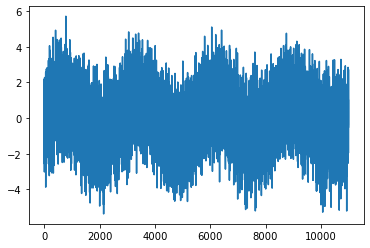

In [7]:
plt.plot(y)

### Define the white noise covariance

In [8]:
C_n = np.eye(P.shape[0]) 

### Construct the baselines matrix F, just some 1s along columns

In [9]:
#Baselines matrix F

n_baseline = 100

F = np.zeros((n_baseline, len(y)))

assert len(y) % n_baseline == 0

cutoff = len(y) // n_baseline
offset = 0 
for i in range(n_baseline):
    F[i][offset:offset+cutoff] = 1
    offset+=cutoff
    
F = F.T

F

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Construct the projection matrix Z from the destriping paper, and setup the CG equation

In [16]:
#destriping. C_n = C_n ^-1 in this simple case 
Z = np.eye(len(y)) - P @ np.linalg.inv(P.T @ C_n @ P) @ P.T @ C_n

#Ax = b
A = F.T @ C_n @ Z @ F
b = F.T @ C_n @ Z @ y

In [11]:
#Solution for amplitudes
a = np.linalg.solve(A, b)

### Check F * a and see if it approximates the input n_corr. Looks fine

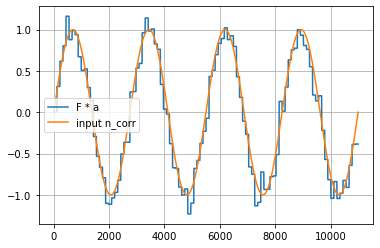

In [17]:
plt.plot(F @ a, label='F * a')
plt.plot(n_corr, label='input n_corr')
plt.grid()
plt.legend()

### Solve for the map! m_destripe is the destriping solution, and m_bin just bins the map

In [13]:
m_solver = np.linalg.inv(P.T @ C_n @ P) @ P.T @ C_n 
m_destripe = m_solver @ (y - F @ a) #Destriping solution
m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
m_bin -= np.mean(m_bin)

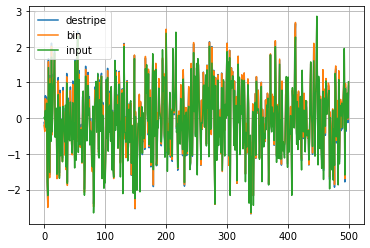

In [14]:
plt.plot(m_destripe, label='destripe')
plt.plot(m_bin, label='bin')
plt.plot(m, label='input')
plt.grid()
plt.legend()

### Plot errors

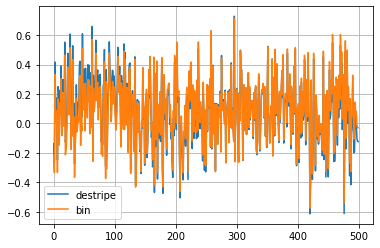

In [15]:
plt.plot(m_destripe - m, label='destripe')
plt.plot(m_bin - m, label='bin')
plt.grid()
plt.legend()

### The binned solution is somehow always very close (or even better) than the destriping solution, even if I crank up n_corr. Don't really understand